In [1]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
!pip install scispacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 21.0 MB/s eta 0:00:00


In [3]:
from sentence_transformers import SentenceTransformer

import scispacy
import spacy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [4]:
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 30.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_sm: filename=en_core_sci_sm-0.5.4-py3-none-any.whl size=14778487 sha256=0c55542652e4669152cbc92ef1d0ef7b97dff5b2a849d1b4c06887125606496e
  Stored in directory: /root/.cache/pip/wheels/7f/29/44/dd461872b8547b8e8007f03418fb8061f5c05c71447982bcff
Successfully built en_core_sci_sm


### Data loading

In [1]:
import pandas as pd
label_dic = {"BACKGROUND": 0, "OBJECTIVE": 1, "METHODS": 2, "RESULTS": 3, "CONCLUSIONS": 4}
indice_to_label = ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]
def load(chemin):
    # We extract the text and the labels from the file
    sentences = []
    labels = []

    with open(chemin, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line and not line.startswith("###"):  # We don't look at the number of the text, and if we are at the end of the text we finish

                label, sentence = line.split("\t", 1)  # We split the label and the text
                sentences.append(sentence.strip())
                labels.append(label_dic[label])

    res = pd.DataFrame({"sentence": sentences, "label": labels}) # we return a dataframe
    return res


We consider that the train, dev and test files from the 200k folder are already downloaded on the current folder.

In [2]:
# We split the train set between the x values (the texts) and the y value (the labels)
train_df = load("train.txt")
train_x = train_df['sentence']
train_y = train_df['label']

In [10]:
train_df.shape

(2211861, 2)

In [11]:
for l in range(5) :
    print("Number of elements from the label ", indice_to_label[l], " (from the 200k): ", train_df[train_df['label'] == l].shape[0], ' soit ', ((train_df[train_df['label'] == l].shape[0])/train_df.shape[0])*100 , "%")

Number of elements from the label  BACKGROUND  (from the 200k):  196689  soit  8.89246657000598 %
Number of elements from the label  OBJECTIVE  (from the 200k):  186601  soit  8.436380043773093 %
Number of elements from the label  METHODS  (from the 200k):  722586  soit  32.668689397751486 %
Number of elements from the label  RESULTS  (from the 200k):  766271  soit  34.6437230910984 %
Number of elements from the label  CONCLUSIONS  (from the 200k):  339714  soit  15.358740897371037 %


In [7]:
# We split the test set between the x values (the texts) and the y value (the labels)
test_df = load("test.txt")
test_x = test_df['sentence']
test_y = test_df['label']

In [9]:
# We split the development set between the x values (the texts) and the y value (the labels)
dev_df = load("dev.txt")
dev_x = dev_df['sentence']
dev_y = dev_df['label']

### Data representation

In [10]:
## Baseline : I choosed TF-IDF with unigrams and bigrams

In [11]:

nlp = spacy.load("en_core_sci_sm")

# Function to preprocess the abstracts (lemmatization, stopwords, and punctuation)
def preprocess(text):
    doc = nlp(text)
    res =  " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct  and not token.is_space]) # we collect the lemmatized token, suppress the stop words and the white space
    return res

/usr/local/lib/python3.11/dist-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [12]:
tf_uni_bi = TfidfVectorizer(tokenizer=preprocess, ngram_range = (1,2), stop_words='english', max_df = 0.8)

We will only work with 20000 texts for each set

In [13]:
# We transform the data in each set with the tf-idf with unigrams and bigrams representation
X_train_tf_uni_bi = tf_uni_bi.fit_transform(train_x[:20000])
X_dev_tf_uni_bi = tf_uni_bi.transform(dev_x[:20000])
X_test_tf_uni_bi = tf_uni_bi.transform(test_x[:20000])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'r', 's', 't', 'u', 'y'] not in stop_words.
  warnings.warn(


In [14]:
print(X_train_tf_uni_bi)

  (0, 665)	0.06917863079401228
  (0, 698)	0.15254669934538634
  (0, 1129)	0.11053946299432092
  (0, 964)	0.08615630799282108
  (0, 487)	0.041953614323518275
  (0, 1215)	0.06964092703025414
  (0, 632)	0.03867867379996753
  (0, 76)	0.053514098305383354
  (0, 750)	0.06395412892395284
  (0, 731)	0.09035865002573328
  (0, 618)	0.20893196007146997
  (0, 831)	0.19311405424946249
  (0, 623)	0.03669955300995533
  (0, 1002)	0.08658708076709636
  (0, 677)	0.12788726254522984
  (0, 619)	0.13951243135476207
  (0, 867)	0.1546839604012512
  (0, 538)	0.04834351012556959
  (0, 27)	0.12792926125374757
  (0, 726)	0.27170408075504743
  (0, 1130)	0.23076208532376435
  (0, 22)	0.1177712844536923
  (0, 541)	0.06867777758233312
  (0, 722)	0.09514834983826877
  (0, 1009)	0.042449254838735406
  :	:
  (19999, 912)	0.16725435273317005
  (19999, 1079)	0.11991189665671917
  (19999, 1014)	0.08323909809393631
  (19999, 1077)	0.22492028032857453
  (19999, 957)	0.18246367995222412
  (19999, 21)	0.10193985627446808
  (1

In [15]:
## Representation with a Sentence Transformer Bert model trained on PubMed

In [16]:
# 1. Load a pretrained Sentence Transformer model
# https://huggingface.co/eladogruyol/pubmedbert-base-embeddings-base-sentence-transformer
# this model was trained on pubmed but the data is not available
model = SentenceTransformer("eladogruyol/pubmedbert-base-embeddings-base-sentence-transformer")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/706k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

We represent the data in each set  with this representation (bert trained on pubmed)

In [17]:
train_x_embeddings = model.encode(train_x[:20000])  # we represent the train set
print(train_x_embeddings.shape)
print(train_x_embeddings)

(20000, 768)
[[-0.05132701 -0.48068658  0.194348   ...  0.0221043   0.3333773
  -0.6490265 ]
 [-0.28997138  0.07314979 -0.48980054 ... -0.16604881  0.18881047
   0.15891138]
 [ 0.27178782  0.1020707  -0.01235938 ... -0.4301725  -0.14551397
  -0.4653903 ]
 ...
 [-0.05070174  0.6554895  -0.07244688 ... -0.31572938 -0.6150529
  -0.14195319]
 [-0.5916684   0.11524522 -0.6265641  ... -0.42618427 -0.5806046
  -0.37975   ]
 [-0.14631675  0.87661725 -0.5382177  ... -0.6884717   1.3413476
  -0.58693045]]


In [18]:
dev_x_embeddings = model.encode(dev_x[:20000]) # we represent the development set
print(dev_x_embeddings.shape)
print(dev_x_embeddings)

(20000, 768)
[[-0.3234896   0.17991346  0.20335127 ... -1.0876421   0.8310503
   0.7074855 ]
 [ 0.05960912  0.7676584  -0.5482478  ... -0.27053675  0.28439015
  -0.3039982 ]
 [-0.188991    0.36544156  0.19350551 ... -0.86446714  0.24642478
   0.28231683]
 ...
 [-0.07738397  0.06381825 -0.4043932  ... -0.65637666 -0.46236297
   0.02988829]
 [ 0.250508    0.40036714 -0.01502903 ... -0.8217363  -0.33467668
  -0.14453883]
 [ 0.11191679  0.33821282 -0.4692861  ... -0.6845096  -0.2029021
  -0.7965164 ]]


In [19]:
test_x_embeddings = model.encode(test_x[:20000]) # we represent the test set
print(test_x_embeddings.shape)
print(test_x_embeddings)

(20000, 768)
[[-0.06403936  1.035293    0.68877316 ...  0.21999231  0.07306694
   0.6781253 ]
 [-0.8420766   0.33557007  0.12163299 ... -0.08956569 -0.46186343
   0.34298772]
 [-0.07801435  0.27295306  0.5171321  ...  0.21514165 -0.20637774
   0.7292622 ]
 ...
 [-0.1017402   0.55268884 -0.13239625 ... -0.6855248  -0.84663886
   0.17995273]
 [ 0.3212523   0.06421698  0.44879606 ... -0.45917857  0.31065157
   0.41101798]
 [-0.3328433   0.85018975 -0.29360238 ... -0.5782778  -0.18075693
  -0.27809322]]


### Predictions

We use a LogisticRegression Model to predict the classification, we choosed the hyper parameters by tuning them (the method used is at the end of the notebook)

In [20]:
clf_tfidf = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=100000) # our prediction model

In [21]:
clf_bert = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=100000) # our prediction model

In [22]:
# Baseline :
clf_tfidf.fit(X_train_tf_uni_bi, train_y[:20000])

LogisticRegression(C=1, max_iter=100000, solver='saga')

In [23]:
# BERT
clf_bert.fit(train_x_embeddings, train_y[:20000])

LogisticRegression(C=0.1, max_iter=100000, solver='liblinear')

In [24]:
y_pred_tfidf = clf_tfidf.predict(X_test_tf_uni_bi) # we predict the test set

In [25]:
y_pred_bert= clf_bert.predict(test_x_embeddings) # we predit the test set

In [26]:
y_pred_bert

array([0, 0, 0, ..., 3, 3, 3])

### Score

In [27]:
accuracy_baseline = accuracy_score(test_y[:20000], y_pred_tfidf)
print(f'TFIDF uni et bigram : Accuracy: {accuracy_baseline:.4f}')

TFIDF uni et bigram : Accuracy: 0.6452


In [28]:
print("\nStatistical results for the bert:")
print(classification_report(test_y[:20000], y_pred_tfidf))


Statistical results for the bert:
              precision    recall  f1-score   support

           0       0.37      0.19      0.25      1814
           1       0.48      0.32      0.39      1580
           2       0.66      0.80      0.72      6716
           3       0.77      0.75      0.76      6910
           4       0.48      0.50      0.49      2980

    accuracy                           0.65     20000
   macro avg       0.55      0.51      0.52     20000
weighted avg       0.63      0.65      0.63     20000



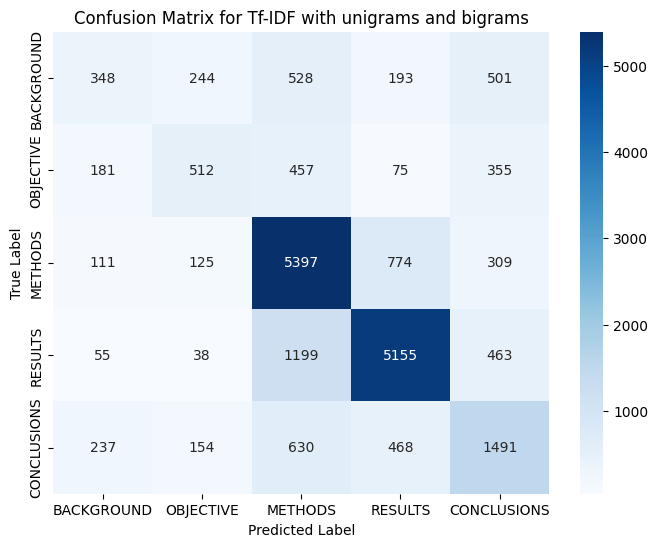

In [29]:
confusion_matrice = confusion_matrix(test_y[:20000], y_pred_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrice, annot=True, fmt='d', cmap='Blues', xticklabels=indice_to_label, yticklabels=indice_to_label)
plt.title('Confusion Matrix for Tf-IDF with unigrams and bigrams')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [30]:
accuracy_baseline = accuracy_score(test_y[:20000], y_pred_bert)
print(f'Bert : Accuracy: {accuracy_baseline:.4f}')

Bert : Accuracy: 0.8426


In [31]:
print("\nStatistical results for the bert:")
print(classification_report(test_y[:20000], y_pred_bert))


Statistical results for the bert:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1814
           1       0.71      0.61      0.66      1580
           2       0.89      0.94      0.91      6716
           3       0.89      0.91      0.90      6910
           4       0.78      0.76      0.77      2980

    accuracy                           0.84     20000
   macro avg       0.78      0.76      0.77     20000
weighted avg       0.84      0.84      0.84     20000



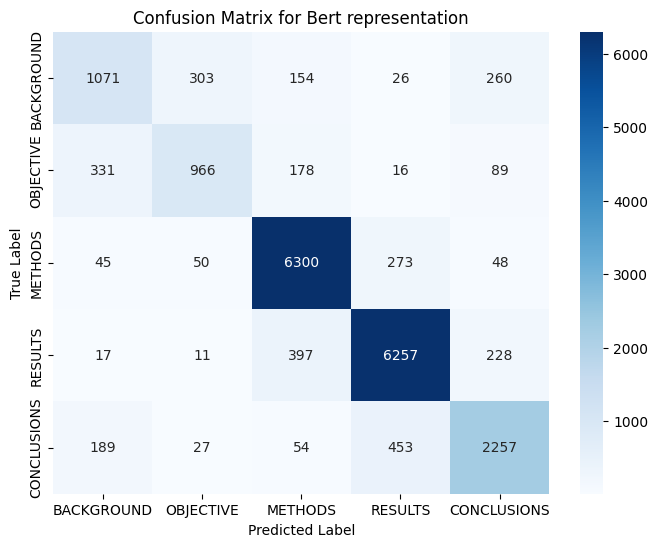

In [32]:
confusion_matrice = confusion_matrix(test_y[:20000], y_pred_bert)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrice, annot=True, fmt='d', cmap='Blues', xticklabels=indice_to_label, yticklabels=indice_to_label)
plt.title('Confusion Matrix for Bert representation')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Error Analysis

#### TF-IDF

In [ ]:
cpt = 0
i = 0
sentences = []
labels_w = []
labels_r = []
while i < len(y_pred_tfidf) and cpt < 5:
    if y_pred_tfidf[i] <= 1 and y_pred_tfidf[i] != test_y[i] :
        cpt += 1
        sentences.append(X_test_tf_uni_bi[i])
        labels_w.append(indice_to_label[y_pred_tfidf[i]])
        labels_r.append(indice_to_label[test_y[i]])
    i += 1


In [ ]:
for i in range(len(sentences)) :
    print(sentences[i])
    print("Wrong Label : ", labels_w[i])
    print("Right label : ", labels_r[i])

#### SBERT

In [ ]:
cpt = 0
i = 0
labels_w = []
labels_r = []
while i < len(y_pred_bert) and cpt < 5:
    if y_pred_bert[i] <= 1 and y_pred_bert[i] != test_y[i] :
        cpt += 1
        sentences.append(test_x_embeddings[i])
        labels_w.append(indice_to_label[y_pred_bert[i]])
        labels_r.append(indice_to_label[test_y[i]])
    i += 1

In [ ]:
for i in range(len(sentences)) :
    print(sentences[i])
    print("Wrong Label : ", labels_w[i])
    print("Right label : ", labels_r[i])

### Hyperparameters tuning

In [33]:
# Hyperparameters to test

# possible values for
solver_val = ['liblinear', 'saga']  # the solver
penalty_val = ['l1', 'l2']  # the penalty
C_val = [0.01, 0.1, 1, 10]  # C (the regularisation)


In [34]:
best_accuracy_tfidf = 0
best_accuracy_bert = 0

# We loop on all the possible values for all the parameters for both model (tfidf and bert)
for solver in solver_val:
    for penalty in penalty_val:
        for C in C_val:
            # We fit the model with the hyparameters values and see its results
            log_reg_tfidf = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000)
            log_reg_bert = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000)

            log_reg_tfidf.fit(X_train_tf_uni_bi, train_y[:20000])
            log_reg_bert.fit(train_x_embeddings, train_y[:20000])

            y_pred_tfidf = log_reg_tfidf.predict(X_dev_tf_uni_bi)
            y_pred_bert = log_reg_bert.predict(dev_x_embeddings)

            accuracy_tfidf = accuracy_score(dev_y[:20000], y_pred_tfidf)
            accuracy_bert = accuracy_score(dev_y[:20000], y_pred_bert)

            # If the accuracy of the model is better the our best accuracy we change the value of the best accuracy and the best hyperameters
            if accuracy_tfidf > best_accuracy_tfidf:
                best_accuracy_tfidf = accuracy_tfidf
                best_params_tfidf = {'C': C, 'penalty': penalty, 'solver': solver}

            if accuracy_bert > best_accuracy_bert:
                best_accuracy_bert = accuracy_bert
                best_params_bert = {'C': C, 'penalty': penalty, 'solver': solver}

            print(f'TFIDF : Testing: C={C}, penalty={penalty}, solver={solver}, Accuracy={accuracy_tfidf:.4f}')
            print(f'BERT : Testing: C={C}, penalty={penalty}, solver={solver}, Accuracy={accuracy_bert:.4f}')

print("TFIDF")
print(f'Best Accuracy: {best_accuracy_tfidf:.4f}')
print(f'Best Hyperparameters: {best_params_tfidf}')
print("BERT")
print(f'Best Accuracy: {best_accuracy_bert:.4f}')
print(f'Best Hyperparameters: {best_params_bert}')

TFIDF : Testing: C=0.01, penalty=l1, solver=liblinear, Accuracy=0.4779
BERT : Testing: C=0.01, penalty=l1, solver=liblinear, Accuracy=0.7653
TFIDF : Testing: C=0.1, penalty=l1, solver=liblinear, Accuracy=0.5896
BERT : Testing: C=0.1, penalty=l1, solver=liblinear, Accuracy=0.8364
TFIDF : Testing: C=1, penalty=l1, solver=liblinear, Accuracy=0.6439
BERT : Testing: C=1, penalty=l1, solver=liblinear, Accuracy=0.8397
TFIDF : Testing: C=10, penalty=l1, solver=liblinear, Accuracy=0.6391
BERT : Testing: C=10, penalty=l1, solver=liblinear, Accuracy=0.8364
TFIDF : Testing: C=0.01, penalty=l2, solver=liblinear, Accuracy=0.5289
BERT : Testing: C=0.01, penalty=l2, solver=liblinear, Accuracy=0.8307
TFIDF : Testing: C=0.1, penalty=l2, solver=liblinear, Accuracy=0.6087
BERT : Testing: C=0.1, penalty=l2, solver=liblinear, Accuracy=0.8407
TFIDF : Testing: C=1, penalty=l2, solver=liblinear, Accuracy=0.6423
BERT : Testing: C=1, penalty=l2, solver=liblinear, Accuracy=0.8383
TFIDF : Testing: C=10, penalty=l2

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TFIDF : Testing: C=1, penalty=l1, solver=saga, Accuracy=0.6452
BERT : Testing: C=1, penalty=l1, solver=saga, Accuracy=0.8330


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TFIDF : Testing: C=10, penalty=l1, solver=saga, Accuracy=0.6374
BERT : Testing: C=10, penalty=l1, solver=saga, Accuracy=0.8247
TFIDF : Testing: C=0.01, penalty=l2, solver=saga, Accuracy=0.5416
BERT : Testing: C=0.01, penalty=l2, solver=saga, Accuracy=0.8366
TFIDF : Testing: C=0.1, penalty=l2, solver=saga, Accuracy=0.6213
BERT : Testing: C=0.1, penalty=l2, solver=saga, Accuracy=0.8378


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TFIDF : Testing: C=1, penalty=l2, solver=saga, Accuracy=0.6467
BERT : Testing: C=1, penalty=l2, solver=saga, Accuracy=0.8298
TFIDF : Testing: C=10, penalty=l2, solver=saga, Accuracy=0.6423
BERT : Testing: C=10, penalty=l2, solver=saga, Accuracy=0.8235
TFIDF
Best Accuracy: 0.6467
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
BERT
Best Accuracy: 0.8407
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


TFIDF
Best Accuracy: 0.6468
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
BERT
Best Accuracy: 0.8407
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

We tried to use RandomizedSearchCV but it took too much time (more than 4H) so choose to do it with less possible values and "by hand"